# Выбор локации для скважины

Нужно решить, где бурить новую скважину.

Предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. С помощью модели машинного обучения нужно определить регион, где добыча принесёт наибольшую прибыль. Также необходимо проанализировать возможную прибыль и риски техникой *Bootstrap.*

Кроме объема запасов признаки неизвестны и обозначены как f0, f1 и f2 (как и регионы, тоже просто пронумерованные от 0 до 2) из-за коммерческой тайны. Суть признаков для построения модели не важна, важно знать, что каждый из признаков значим.

Самый выгодный регион определяется по следующим критериям:
- Высокая прибыль;
- Низкие риски (менее 2.5%)

## Загрузка и подготовка данных

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from numpy.random import RandomState
from sklearn.preprocessing import MinMaxScaler

In [2]:
geo_data_0 = pd.read_csv('geo_data_0.csv')
geo_data_1 = pd.read_csv('geo_data_1.csv')
geo_data_2 = pd.read_csv('geo_data_2.csv')

geo_data_0.info()
geo_data_1.info()
geo_data_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null 

In [3]:
geo_data_0.duplicated().any()

False

In [4]:
geo_data_1.duplicated().any()

False

In [5]:
geo_data_2.duplicated().any()

False

Пропусков в данных нет, дубликатов тоже. Взглянем на распределения признаков по регионам.

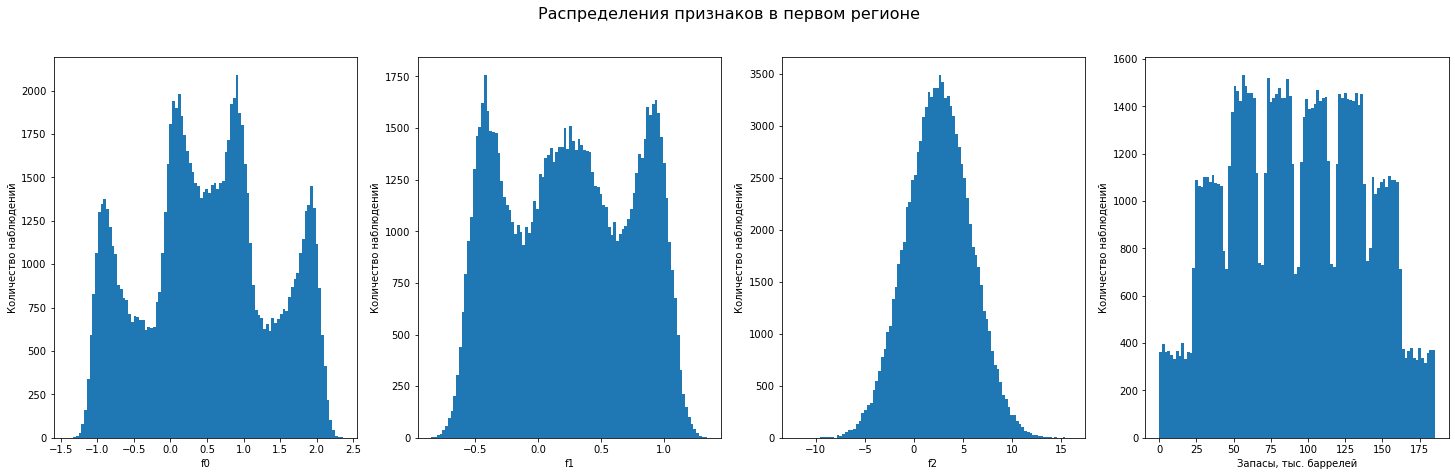

In [6]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(25, 7))

def hist(column, ax):
    ax.hist(column, bins=100)
    ax.set_ylabel('Количество наблюдений')

hist(geo_data_0['f0'], ax1)
hist(geo_data_0['f1'], ax2)
hist(geo_data_0['f2'], ax3)
hist(geo_data_0['product'], ax4)

ax1.set_xlabel('f0')
ax2.set_xlabel('f1')
ax3.set_xlabel('f2')
ax4.set_xlabel('Запасы, тыс. баррелей')
fig.suptitle('Распределения признаков в первом регионе', fontsize=16)
plt.show()

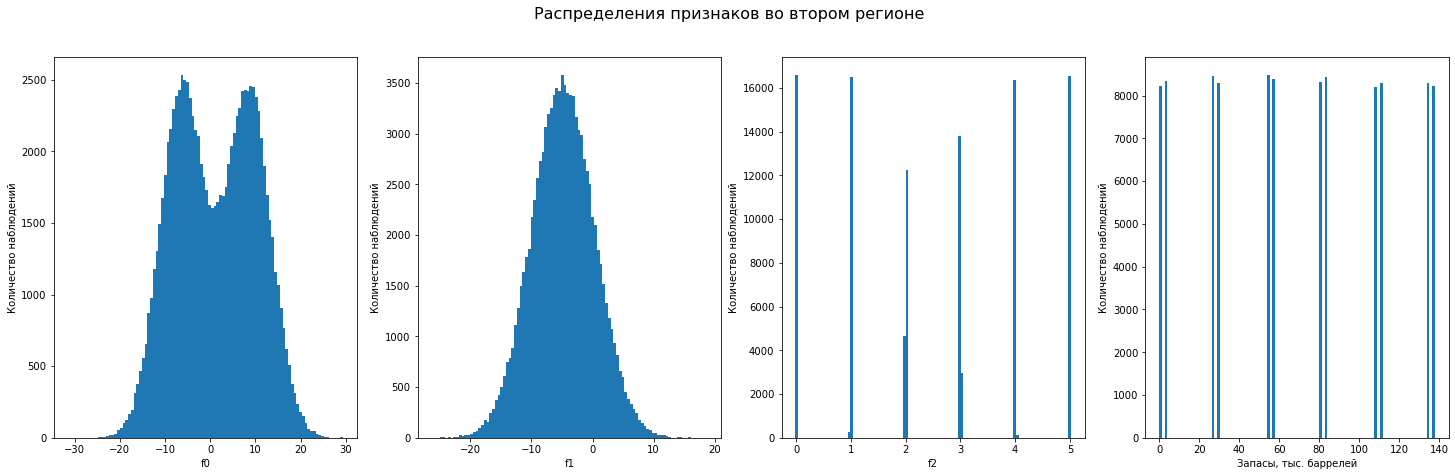

In [7]:
fig, (ax5, ax6, ax7, ax8) = plt.subplots(1, 4, figsize=(25, 7))
      
hist(geo_data_1['f0'], ax5)
hist(geo_data_1['f1'], ax6)
hist(geo_data_1['f2'], ax7)
hist(geo_data_1['product'], ax8)

ax5.set_xlabel('f0')
ax6.set_xlabel('f1')
ax7.set_xlabel('f2')
ax8.set_xlabel('Запасы, тыс. баррелей')
fig.suptitle('Распределения признаков во втором регионе', fontsize=16)
plt.show()

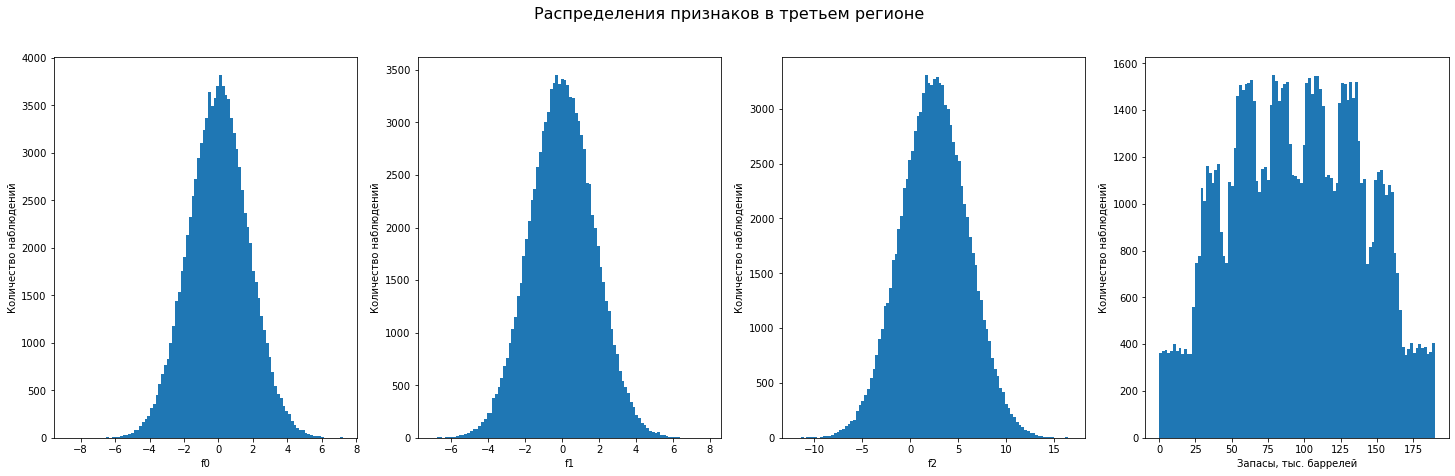

In [8]:
fig, (ax9, ax10, ax11, ax12) = plt.subplots(1, 4, figsize=(25, 7))
      
hist(geo_data_2['f0'], ax9)
hist(geo_data_2['f1'], ax10)
hist(geo_data_2['f2'], ax11)
hist(geo_data_2['product'], ax12)

ax9.set_xlabel('f0')
ax10.set_xlabel('f1')
ax11.set_xlabel('f2')
ax12.set_xlabel('Запасы, тыс. баррелей')
fig.suptitle('Распределения признаков в третьем регионе', fontsize=16)
plt.show()

В первом регионе нормальное распределение только у признака f2. Во втором — у f1. В третьем регионе нормально распределены признаки f1, f2 и f3. Все остальные признаки не описываются нормальным законом. Особенно это заметно во втором регионе: показатели там не распределены, а сгруппированы, то есть, например, f2 там всегда равно числу, близкому к целому или даже на самом деле целому. Наблюдения выглядят так, будто после измерения их определяли в категорию (ближе к 1, ближе к 2 и т.д.), а не просто записывали результат, как в двух других регионах, где f2 распределено нормально.

## Обучение и проверка модели

Для начала разделим данные по каждому региону на 2 выборки — обучающую и тестовую — и выберем целевой признак.

In [9]:
def split(df):
    df_train, df_test = train_test_split(df, test_size=0.25, random_state=322)
    return df_train, df_test

def features(df):
    features = df.drop(['product', 'id'], axis=1)
    return features

def target(df):
    target = df['product']
    return target

In [10]:
df_train0, df_test0 = split(geo_data_0)

features_train0 = features(df_train0)
features_test0 = features(df_test0)
target_train0 = target(df_train0)
target_test0 = target(df_test0)

print('Размеры наборов признаков для первого региона: \n Обучающая выборка:', features_train0.shape,
      '\n Тестовая выборка:', features_test0.shape)
print('Размеры наборов целевых признаков: \n Обучающая выборка:', target_train0.shape,
      '\n Тестовая выборка:', target_test0.shape)

Размеры наборов признаков для первого региона: 
 Обучающая выборка: (75000, 3) 
 Тестовая выборка: (25000, 3)
Размеры наборов целевых признаков: 
 Обучающая выборка: (75000,) 
 Тестовая выборка: (25000,)


In [11]:
df_train1, df_test1 = split(geo_data_1)

features_train1 = features(df_train1)
features_test1 = features(df_test1)
target_train1 = target(df_train1)
target_test1 = target(df_test1)

print('Размеры наборов признаков для второго региона: \n Обучающая выборка:', features_train1.shape,
      '\n Тестовая выборка:', features_test1.shape)
print('Размеры наборов целевых признаков: \n Обучающая выборка:', target_train1.shape,
      '\n Тестовая выборка:', target_test1.shape)

Размеры наборов признаков для второго региона: 
 Обучающая выборка: (75000, 3) 
 Тестовая выборка: (25000, 3)
Размеры наборов целевых признаков: 
 Обучающая выборка: (75000,) 
 Тестовая выборка: (25000,)


In [12]:
df_train2, df_test2 = split(geo_data_2)

features_train2 = features(df_train2)
features_test2 = features(df_test2)
target_train2 = target(df_train2)
target_test2 = target(df_test2)

print('Размеры наборов признаков для третьего региона: \n Обучающая выборка:', features_train2.shape,
      '\n Тестовая выборка:', features_test2.shape)
print('Размеры наборов целевых признаков: \n Обучающая выборка:', target_train2.shape,
      '\n Тестовая выборка:', target_test2.shape)

Размеры наборов признаков для третьего региона: 
 Обучающая выборка: (75000, 3) 
 Тестовая выборка: (25000, 3)
Размеры наборов целевых признаков: 
 Обучающая выборка: (75000,) 
 Тестовая выборка: (25000,)


Данные предсказуемо разделились на ровные выборки. Обучим модели.

In [13]:
def fit_predict(features_train, target_train, features_test, target_test):
    scaler = MinMaxScaler()
    features_train = scaler.fit_transform(features_train)
    features_test = scaler.fit_transform(features_test)
    model = LinearRegression().fit(features_train, target_train)
    pred = model.predict(features_test)
    rmse = mean_squared_error(target_test, pred, squared=False)
    print('Среднее количество сырья (тыс. баррелей):', pred.mean().round(2),
      '\nRMSE модели:', rmse.round(2))
    return pred

In [14]:
print('Первый регион:')

pred0 = fit_predict(features_train0, target_train0, features_test0, target_test0)

Первый регион:
Среднее количество сырья (тыс. баррелей): 80.06 
RMSE модели: 39.77


Судя по RMSE модели для первого региона, модель в среднем ошибается почти на 40 тысяч баррелей, то есть показатель в 90 тысяч баррелей значит, что на самом деле в средней скважине первого региона может лежать как 50 тысяч баррелей (что почти вдвое меньше), так и 130 тысяч (что почти в полтора раза больше).

In [15]:
print('Второй регион:')

pred1 = fit_predict(features_train1, target_train1, features_test1, target_test1)

Второй регион:
Среднее количество сырья (тыс. баррелей): 69.24 
RMSE модели: 1.07


В скважинах второго региона в среднем 69.24 тысяч баррелей нефти (плюс-минус тысяча баррелей), так что предсказания довольно точные.

In [16]:
print('Третий регион:')

pred2 = fit_predict(features_train2, target_train2, features_test2, target_test2)

Третий регион:
Среднее количество сырья (тыс. баррелей): 98.21 
RMSE модели: 40.29


В третьем регионе дела обстоят почти так же, как в первом: среднее количество сырья в скважине — чуть больше 98 тысяч баррелей, модель в среднем ошибается на 40 баррелей.

## Подготовка к расчёту прибыли

Выясним, сколько баррелей должно быть в скважине для безубыточной разработки.

При разведке региона исследуют 500 точек, из которых выбирают 200 лучших для разработки. Бюджет на разработку скважин в регионе — 10 млрд рублей. Один баррель сырья приносит 450 рублей дохода. Доход с каждой единицы продукта составляет 450 тыс. рублей, поскольку объём указан в тысячах баррелей.

Создадим переменные для всех необходимых для расчетов параметров: стоимость разработки скважин (в рублях), количество точек для разработки и доход с единицы продукта (тысячи баррелей).

In [17]:
DEV_COST = 10000000000
NUM_OF_POINTS = 200
UNIT_INCOME = 450000

UNIT_REQUIRED = (DEV_COST / NUM_OF_POINTS) / UNIT_INCOME

print('Для безубыточной разработки в скважине должно быть не менее', round(UNIT_REQUIRED, 2), 'тысяч баррелей нефти')

Для безубыточной разработки в скважине должно быть не менее 111.11 тысяч баррелей нефти


Для безубыточной обработки необходимо больше нефти, чем в среднем предсказано в любом из предложенных регионов. Необходимо проверить, возможна ли прибыль при выборе лучших точек в каждом регионе.

In [18]:
def profit(target, pred, count):
    pred_sorted = pd.Series(pred).sort_values(ascending=False)
    selected = target[pred_sorted.index][:count]
    return (UNIT_INCOME * selected.sum() - DEV_COST)

print('Прибыль в первом регионе:',
      (profit(target_test0.reset_index(drop=True), pred0, NUM_OF_POINTS) / 1000000000).round(2), 'млрд рублей')
print('Прибыль во втором регионе:',
      (profit(target_test1.reset_index(drop=True), pred1, NUM_OF_POINTS) / 1000000000).round(2), 'млрд рублей')
print('Прибыль в третьем регионе:',
      (profit(target_test2.reset_index(drop=True), pred2, NUM_OF_POINTS) / 1000000000).round(2), 'млрд рублей')

Прибыль в первом регионе: 3.45 млрд рублей
Прибыль во втором регионе: 2.42 млрд рублей
Прибыль в третьем регионе: 2.24 млрд рублей


Самый прибыльный регион — первый, он прибыльнее любого из двух других на миллиард рублей. Посчитаем риски для всех регионов.

## Расчёт прибыли и рисков 

In [19]:
def bootstrap(target_test, pred):
    state = RandomState(322)
    profit_values = []
    for i in range(1000):
        subsample_target = target_test.sample(n=500, replace=True, random_state=state)
        subsample_pred = pd.Series(pred)[subsample_target.index]
        p = profit(subsample_target.reset_index(drop=True), subsample_pred.reset_index(drop=True), NUM_OF_POINTS)
        profit_values.append(p)
    profit_values = pd.Series(profit_values)
    losses = profit_values[profit_values < 0]
    loss_probaility = len(losses) / len(profit_values) * 100
    lower = pd.Series(profit_values).quantile(0.025)
    upper = pd.Series(profit_values).quantile(0.975)
    print('Доверительный интервал — от', (lower / 1000000).round(2), 'до', (upper / 1000000).round(2), 'млн рублей')
    print('Средняя прибыль в регионе — ', (p.mean() / 1000000).round(2), 'млн рублей')
    print('Риск убытков —', round(loss_probaility, 2), '%')

In [20]:
bootstrap(target_test0.reset_index(drop=True), pred0)

Доверительный интервал — от -115.34 до 902.93 млн рублей
Средняя прибыль в регионе —  739.3 млн рублей
Риск убытков — 6.6 %


In [21]:
bootstrap(target_test1.reset_index(drop=True), pred1)

Доверительный интервал — от 46.71 до 854.46 млн рублей
Средняя прибыль в регионе —  177.39 млн рублей
Риск убытков — 1.3 %


In [22]:
bootstrap(target_test2.reset_index(drop=True), pred2)

Доверительный интервал — от -204.87 до 865.91 млн рублей
Средняя прибыль в регионе —  221.27 млн рублей
Риск убытков — 11.8 %


Наиболее прибыльные регионы оказались слишком рискованными. При условии, что после оценки рисков можно оставить только регионы с вероятностью убытков менее 2.5%, остается только один регион — второй. Средняя прибыль в этом регионе — всего 177.4 млн рублей, зато риск убытков низкий — всего 1.3%. Исходя из этого для разработки можно предложить второй регион.

Если прибыль во втором регионе кажется низкой, можно провести разработку в первом регионе: при риске убытков в 6.6% (что высоковато) можно получить около 739 млн рублей прибыли.

Третий регион разрабатывать не стоит: там самые высокие риски убытков, а средняя прибыль совсем незначительно выше средней прибыли во втором регионе.